In [63]:
# 引入库
import graspologic
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn.manifold import TSNE
import random
from utils import *
from train import *
from operation import *
from mutation import *
import torch
%matplotlib inline

In [59]:
n = [250,250]
P = [[0.215,0.2],
     [0.2,0.215]]
# 通过sbm生成了两个类别各500个节点，其中P对角线上的概率代表社区内节点有边的概率，非对角线代表社区间节点有边的概率
adj = graspologic.simulations.sbm(n=n,p=P)
#将P操作增加为三个无参聚合
adj_nor = aug_normalized_adjacency(adj)
adj_com = aug_compare_adjacency(adj)
adj_sing = adj_com + sp.eye(adj_com.shape[0])

#关于行列标准化的无参聚集算子增加
adj_row = aug_row_normalizaed_adjacency(adj)
adj_col = aug_col_normalizaed_adjacency(adj)
adj_row = sparse_mx_to_torch_sparse_tensor(adj_row).float().cuda()
adj_col = sparse_mx_to_torch_sparse_tensor(adj_col).float().cuda()

adj_nor = sparse_mx_to_torch_sparse_tensor(adj_nor).float().cuda()
adj_com = sparse_mx_to_torch_sparse_tensor(adj_com).float().cuda()
adj_sing = sparse_mx_to_torch_sparse_tensor(adj_sing).float().cuda()
print(adj.shape)
labels = [random.randint(0,1) for i in range(500)]
# 根据多元正态分布生成特征
# mean = (0.2,0.2)
# cov = np.array([
#     [0.2,0],
#     [0,0.4]
# ])
# features = np.random.multivariate_normal(mean,cov,(500),'raise')

a = np.eye(200)*np.random.uniform(-1,1,200)
cov = np.dot(a,a.T)
features = np.random.multivariate_normal(np.random.uniform(-0.5,1,200),cov,500,'raise')

# 进行类型转换
features = torch.FloatTensor(features)
labels = torch.LongTensor(labels)
labels = labels.cuda()
features = features.cuda()

nb_class = (torch.max(labels) + 1).cpu().numpy()
Y_onehot =  torch.zeros(labels.shape[0], nb_class).scatter_(1, labels.unsqueeze(-1).cpu(), 1)


nb_each_class = torch.sum(Y_onehot, dim = 0)
nb_each_class_inv = torch.tensor(np.power(nb_each_class.numpy(), -1).flatten())
nb_each_class_inv_mat = torch.diag(nb_each_class_inv)

Y_onehot = Y_onehot.cuda()
nb_each_class_inv_mat = nb_each_class_inv_mat.cuda()
d_score = get_division_score(features,Y_onehot,nb_each_class_inv_mat)
print('the score of current is %f'%(d_score))

(500, 500)
the score of current is 1.000000


In [67]:
print(features.shape)
tsne = TSNE(n_components=2)
new_features = tsne.fit_transform(features.cpu())
print(type(new_features))

torch.Size([500, 200])


/media/usr/miniconda3/miniconda3/envs/DFG-NAS/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/media/usr/miniconda3/miniconda3/envs/DFG-NAS/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<class 'numpy.ndarray'>


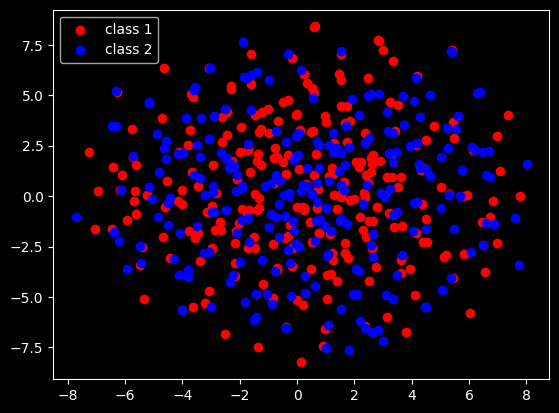

In [68]:
# features = features.cpu().numpy()
label1 = []
label2 = []
for i in range(len(labels)):
    if labels[i] == 0:
        label1.append(i)
    else:
        label2.append(i)
label1 = torch.tensor(label1)
label2 = torch.tensor(label2)
label1 = label1.cuda()
label2 = label2.cuda()
new_features = torch.FloatTensor(new_features)
new_features = new_features.cuda()
plt.scatter(new_features[label1, 0].cpu().numpy(), new_features[label1, 1].cpu().numpy(),c='r',label='class 1')
plt.scatter(new_features[label2, 0].cpu().numpy(), new_features[label2, 1].cpu().numpy(),c='b',label='class 2')
plt.legend()
plt.show()

/media/usr/miniconda3/miniconda3/envs/DFG-NAS/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/media/usr/miniconda3/miniconda3/envs/DFG-NAS/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


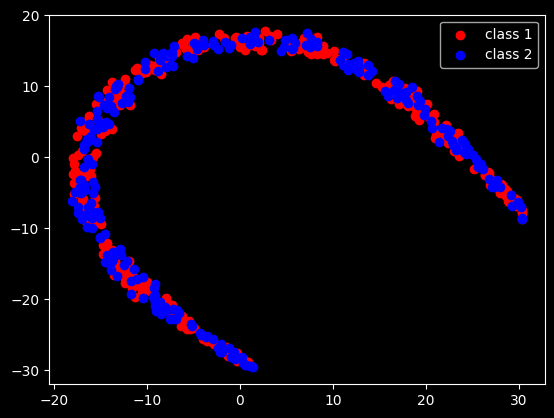

1.0

In [71]:
p_features = adj_nor.matmul(features)
p_features = adj_col.matmul(p_features)
# 降维后转换为tensor放在cuda上(tsne使用numpy)
np_features = tsne.fit_transform(p_features.cpu())
np_features = torch.FloatTensor(np_features)
np_features = np_features.cuda()

plt.scatter(np_features[label1, 0].cpu().numpy(), np_features[label1, 1].cpu().numpy(),c='r',label='class 1')
plt.scatter(np_features[label2, 0].cpu().numpy(), np_features[label2, 1].cpu().numpy(),c='b',label='class 2')
plt.legend()
plt.show()
d_score = get_division_score(p_features,Y_onehot,nb_each_class_inv_mat)
d_score

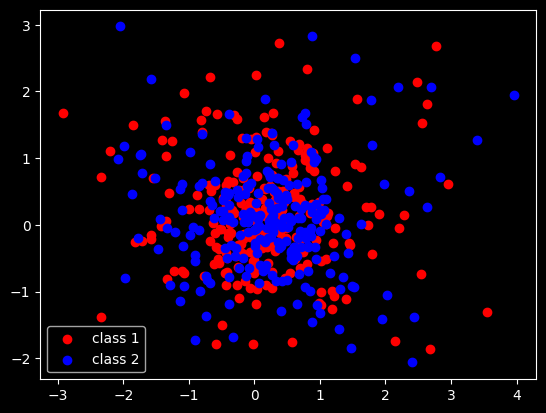

1.0

In [72]:
# 建立两个T层
layer1 = MLP(200,64,0.8)
layer2 = MLP(64,2,0.8,True)
layer1 = layer1.cuda()
layer2 = layer2.cuda()
t_features = layer1(features)
t_features = layer2(t_features)
plt.scatter(t_features[label1, 0].cpu().detach().numpy(), t_features[label1, 1].cpu().detach().numpy(),c='r',label='class 1')
plt.scatter(t_features[label2, 0].cpu().detach().numpy(), t_features[label2, 1].cpu().detach().numpy(),c='b',label='class 2')
plt.legend()
plt.show()
d_score = get_division_score(t_features,Y_onehot,nb_each_class_inv_mat)
d_score

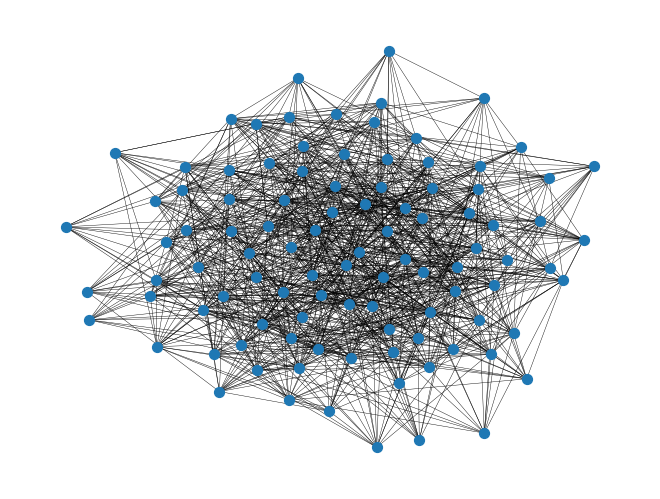

In [4]:
Graph = nx.from_numpy_array(adj)
nx.draw(Graph, with_labels=False, node_size = 50, width = 0.3)